# Bayesian Outlier Modeling 
## For N-of-1 Outlier Analysis of TCGA against Normal Sets

Model outliers using a linear combination of approximations. Each background dataset, $X_i$, for each gene $j$, contributes a posterior distribution of expression $y_{i,j}$ to a linear model that learns the vector of $\beta$ weights corresponding to each background comparison distribution to model an $n$-of-1 tumor sample's distribution $z_j$. Samples drawn from the posterior distribution $z_j$ are then compared to the n-of-1 sample.

# Inputs

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

import rnaseq_lib3 as r

In [7]:
df = pd.read_hdf('/mnt/data/Objects/tcga_gtex_tpm_norm_filt.hd5')
df.head(2)

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,0.000000,10.302941,10.712460,2.750618,7.780669,...,0.000000,0.0,0.0,0.150556,0.0,0.000000,0.0,0.070387,0.790754,0.815589
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,2.970847,8.778885,10.445933,12.393268,8.440056,...,0.176318,0.0,0.0,0.411426,0.0,0.176318,0.0,0.622930,0.042644,0.378503


In [8]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Subset by dataset

In [9]:
cols = df.columns[:5].tolist()
drug_df = df[cols + drug_genes]

gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

sub = {
    'gtex': gtex,
    'normal': normal,
    'tumor': tumor}

In [10]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(sub['gtex'][gene], label='gtex')
    sns.kdeplot(sub['normal'][gene], label='normal')
    sns.kdeplot(sub['tumor'][gene], label='tumor')    
    plt.title(gene);

# Simple Model

## Learn Fits

Pick N-of-1

In [11]:
n_of_1 = tumor.loc[np.random.choice(tumor.id)]
n_of_1.id

'TCGA-BP-4985-01'

Subtract from tumor

In [13]:
tumor_ = tumor.drop(n_of_1.id)

Learn fits

In [19]:
genes = drug_genes

In [20]:
fits = {}
datasets = [('gtex', gtex), ('normal', normal), ('tumor', tumor_)]

for gene in genes:
    for name, dataset in datasets:
        key = f'{gene}-{name}'
        fits[key] = st.norm.fit(dataset[gene])

## Build Model

In [36]:
def train_linear(n_of_1, genes, datasets, fits, n_samples=200, tune=1000):
    """
    n_of_1: tumor sample 
    genes: genes to learn
    datasets: datasets to include
    fits = fits[gene-dataset] contain MAP of expression
    n_samples = Samples to learn
    """
    z = {}
    with pm.Model() as model:
        # Priors for linear model
        alpha = pm.Normal('alpha', 0, 5)
        beta = pm.Normal('beta', 0, 5, shape=len(datasets))
        
        # One sigma prior for each gene
        # Since this doesn't get used to generate the posterior, I'm unsure
        # of its actual purpose or if we can find a way to remove it.
        # TODO: Try different ranges of Sigma to see if it improves A/B traceplots
        sigma = pm.Uniform('sigma', 0, 1, shape=len(genes))
        
        # Convert fits into Normal RVs
        exp_rvs = {key: pm.Normal(key, *fits[key]) for key in fits}
        
        # Define linear model for each gene
        mu = {}
        for i, gene in enumerate(genes):
            mu[gene] = alpha
            for j, (name, _) in enumerate(datasets):
                mu[gene] += exp_rvs[f'{gene}-{name}'] * beta[j]
        
        # Define z distributions for each mu
        for i, gene in enumerate(genes):
            obs = n_of_1[gene]
            z[gene] = pm.Normal(gene, mu=mu[gene], sd=sigma[i], observed=obs)
        
        # Calculate trace
        trace = pm.sample(n_samples, tune=tune, 
                          nuts_kwargs={'target_accept': 0.95})
    return model, trace

## Train

In [31]:
g1 = 'JAK2'
g2 = 'MET'

Find an example gene that is not an outlier

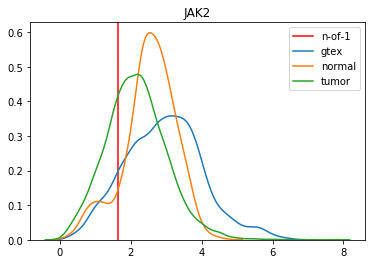

In [44]:
plot_gene_dist(n_of_1, gene=g1)

An example gene that is an outlier

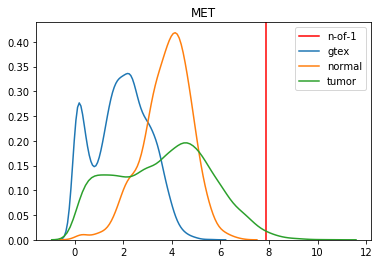

In [45]:
plot_gene_dist(n_of_1, gene=g2)

In [37]:
model, trace = train_linear(n_of_1, genes, datasets, fits)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '18755' (I am process '18590')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '18755' (I am process '18590')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '18755' (I am process '18590')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '18755'

Sampling 4 chains: 100%|██████████| 4800/4800 [2:38:31<00:00,  7.88s/draws]  
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9042750359924059, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
T

## TracePlot

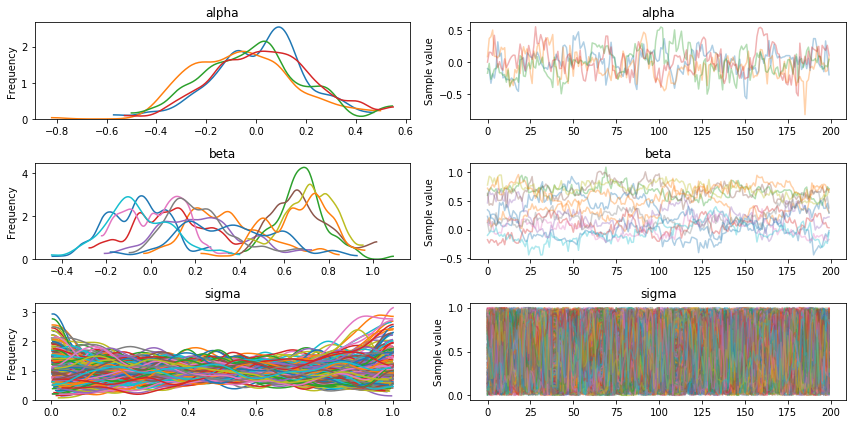

In [38]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);

## Parameter Estimates

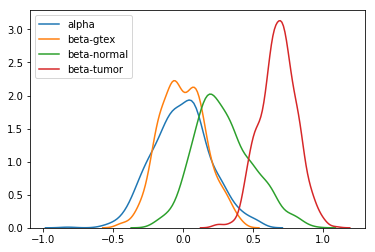

In [43]:
sns.kdeplot(trace['alpha'], label='alpha')
sns.kdeplot(trace['beta'][:,0], label='beta-gtex')
sns.kdeplot(trace['beta'][:,1], label='beta-normal')
sns.kdeplot(trace['beta'][:,2], label='beta-tumor');

## Posterior Sampling

In [56]:
def posterior_check(trace, gene, n_of_1=n_of_1, gtex=gtex, normal=normal):
    # Get Median of priors
    a = np.median(trace['alpha'])
    b1 = np.median(trace['beta'][:,0])
    b2 = np.median(trace['beta'][:,1])
    b3 = np.median(trace['beta'][:,2])
    
    # 1000 samples from our datasets
    g1000 = np.random.choice(gtex[gene], 1000)
    n1000 = np.random.choice(normal[gene], 1000)
    t1000 = np.random.choice(tumor[gene], 1000)
    
    # Calculate z based on samples
    z = a + b1 * g1000 + b2 * n1000 + b3 * t1000
    
    # Calculate PPP
    z_true = n_of_1[gene]
    ppp = sum(z_true < z) / len(z)

    # Plot
    plt.axvline(n_of_1[gene], color='red', label='z-true')
    plt.title(f'{gene} - P: {ppp}')
    sns.kdeplot(z, label='z-posterior');

For known non-outlier

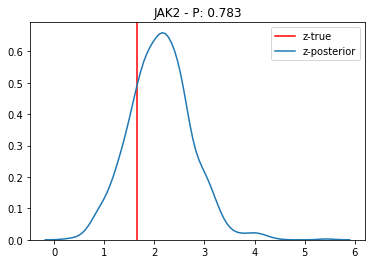

In [57]:
posterior_check(trace, gene=g1)

For known outlier

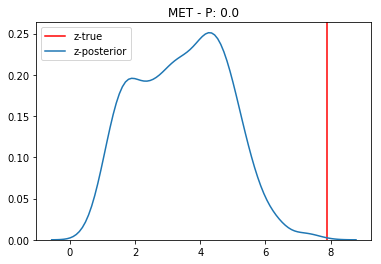

In [58]:
posterior_check(trace, gene=g2)